# Inportando bibliotecas

In [1]:
#!pip install openbb

In [2]:
#!pip install stable-baselines3 gym-anytrading gym
#!pip install finta
#!pip install quantstats
#!pip install --upgrade scipy
#!pip install matplotlib

In [3]:
# Gym stuff
from openbb_terminal.sdk import openbb
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3 import A2C,PPO,DQN

#Quant Finance
from finta import TA
import quantstats as qs

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gym_anytrading.envs import Actions

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

# Importando dados
Dados serao pegos do alphavantagem:replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key

In [4]:
"""# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=AAPL&interval=5min&outputsize=full&apikey=XURVM7ULVMY11ROO&datatype=csv'
data = pd.read_csv(url)
#data.index = data.timestamp
#data.drop('timestamp',inplace=True,axis=1)

data = data.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data.sort_values('timestamp', ascending=True, inplace=True)

data.head()
"""

'# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key\nurl = \'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=AAPL&interval=5min&outputsize=full&apikey=XURVM7ULVMY11ROO&datatype=csv\'\ndata = pd.read_csv(url)\n#data.index = data.timestamp\n#data.drop(\'timestamp\',inplace=True,axis=1)\n\ndata = data.rename(columns = {\'open\': \'Open\', \'high\': \'High\', \'low\': \'Low\', \'close\': \'Close\', \'volume\': \'Volume\'})\n\ndata[\'timestamp\'] = pd.to_datetime(data[\'timestamp\'])\ndata.set_index(\'timestamp\', inplace=True)\ndata.sort_values(\'timestamp\', ascending=True, inplace=True)\n\ndata.head()\n'

In [5]:
import yfinance as yf

In [6]:
# Define the ticker symbol
ticker_symbol = "VALE3.SA"

# Create a ticker object
ticker = yf.Ticker(ticker_symbol)

# Download historical data
data = ticker.history(start="1990-01-01", end="2022-12-31", interval='1d')
#data = ticker.history(period="720d", interval='1h')

In [7]:
colunas = ['Open','High','Low','Close','Volume']
data = data[colunas]

In [8]:
data.shape

(5778, 5)

In [9]:
#Data tyeps neet to be numbers not objects
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

# Adicionando mais variaveis 


### Indicadores tecnicos

In [10]:
#Create columns for technical indicators & add them to the dataframe
data['RSI_10'] = TA.RSI(data,10)
data['RSI_100'] = TA.RSI(data,100)
data['SMA'] = TA.SMA(data)
data['OBV'] = TA.OBV(data)
data['SMA_L'] = TA.SMA(data, 50)
data['VWAP'] = TA.VWAP(data)
data['EMA'] = TA.EMA(data)
data['ATR'] = TA.ATR(data)
data = data.join(TA.MACD(data))
data.fillna(0, inplace=True)

In [11]:
data.head()

Open      High       Low     Close   Volume  \
Date                                                                         
2000-01-03 00:00:00-02:00  1.616371  1.635998  1.616371  1.616371   585600   
2000-01-04 00:00:00-02:00  1.600976  1.604440  1.577885  1.577885   782400   
2000-01-05 00:00:00-02:00  1.558643  1.577885  1.558643  1.577885  1876800   
2000-01-06 00:00:00-02:00  1.577885  1.616371  1.577885  1.577885   792000   
2000-01-07 00:00:00-02:00  1.597128  1.643695  1.597128  1.635613  5347200   

                              RSI_10    RSI_100  SMA        OBV  SMA_L  \
Date                                                                     
2000-01-03 00:00:00-02:00   0.000000   0.000000  0.0        0.0    0.0   
2000-01-04 00:00:00-02:00   0.000000   0.000000  0.0  -782400.0    0.0   
2000-01-05 00:00:00-02:00   0.000000   0.000000  0.0        0.0    0.0   
2000-01-06 00:00:00-02:00   0.000000   0.000000  0.0        0.0    0.0   
2000-01-07 00:00:00-02:00  67.294569  60.721197  0.0  4564800.0    0.0   

                               VWAP       EMA  ATR      MACD    SIGNAL  
Date                                                                    
2000-01-03 00:00:00-02:00  1.622913  1.616371  0.0  0.000000  0.000000  
2000-01-04 00:00:00-02:00  1.602223  1.594990  0.0 -0.000863 -0.000480  
2000-01-05 00:00:00-02:00  1.584436  1.587980  0.0 -0.001100 -0.000734  
2000-01-06 00:00:00-02:00  1.585668  1.584560  0.0 -0.001181 -0.000885  
2000-01-07 00:00:00-02:00  1.608353  1.599747  0.0  0.001097 -0.000296

### Adicionando lags dos precos

In [12]:
lags = 5
cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['Close'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

In [13]:
data.head()

Open      High       Low     Close   Volume  \
Date                                                                         
2000-01-10 00:00:00-02:00  1.731826  1.770311  1.731826  1.770311  2980800   
2000-01-11 00:00:00-02:00  1.770311  1.781857  1.758766  1.774159   326400   
2000-01-12 00:00:00-02:00  1.778008  1.808796  1.774159  1.791478  5068800   
2000-01-13 00:00:00-02:00  1.851130  1.851130  1.851130  1.851130   120000   
2000-01-14 00:00:00-02:00  1.855363  1.885766  1.855363  1.885766  3484800   

                              RSI_10    RSI_100  SMA         OBV  SMA_L  \
Date                                                                      
2000-01-10 00:00:00-02:00  88.084027  83.843445  0.0   7545600.0    0.0   
2000-01-11 00:00:00-02:00  88.319718  84.113330  0.0   7872000.0    0.0   
2000-01-12 00:00:00-02:00  89.370952  85.234512  0.0  12940800.0    0.0   
2000-01-13 00:00:00-02:00  92.094124  88.145352  0.0  13060800.0    0.0   
2000-01-14 00:00:00-02:00  93.215515  89.373949  0.0  16545600.0    0.0   

                               VWAP       EMA  ATR      MACD    SIGNAL  \
Date                                                                     
2000-01-10 00:00:00-02:00  1.644304  1.645980  0.0  0.008206  0.002009   
2000-01-11 00:00:00-02:00  1.647578  1.678418  0.0  0.012798  0.004739   
2000-01-12 00:00:00-02:00  1.688647  1.705589  0.0  0.016494  0.007564   
2000-01-13 00:00:00-02:00  1.689738  1.739209  0.0  0.021763  0.010844   
2000-01-14 00:00:00-02:00  1.720059  1.772047  0.0  0.026968  0.014457   

                              lag_1     lag_2     lag_3     lag_4     lag_5  
Date                                                                         
2000-01-10 00:00:00-02:00  1.635613  1.577885  1.577885  1.577885  1.616371  
2000-01-11 00:00:00-02:00  1.770311  1.635613  1.577885  1.577885  1.577885  
2000-01-12 00:00:00-02:00  1.774159  1.770311  1.635613  1.577885  1.577885  
2000-01-13 00:00:00-02:00  1.791478  1.774159  1.770311  1.635613  1.577885  
2000-01-14 00:00:00-02:00  1.851130  1.791478  1.774159  1.770311  1.635613

### Adcionando datas

In [14]:
data['year'] = data.index.year
data['month'] = data.index.month
data['weekday'] = data.index.weekday

In [15]:
data

Open       High        Low      Close  \
Date                                                                    
2000-01-10 00:00:00-02:00   1.731826   1.770311   1.731826   1.770311   
2000-01-11 00:00:00-02:00   1.770311   1.781857   1.758766   1.774159   
2000-01-12 00:00:00-02:00   1.778008   1.808796   1.774159   1.791478   
2000-01-13 00:00:00-02:00   1.851130   1.851130   1.851130   1.851130   
2000-01-14 00:00:00-02:00   1.855363   1.885766   1.855363   1.885766   
...                              ...        ...        ...        ...   
2022-12-23 00:00:00-03:00  81.003635  82.181454  80.813667  81.991486   
2022-12-26 00:00:00-03:00  82.086465  83.150305  82.000981  82.741867   
2022-12-27 00:00:00-03:00  83.587245  85.154508  83.083823  84.717575   
2022-12-28 00:00:00-03:00  84.717571  85.686420  84.252137  84.527596   
2022-12-29 00:00:00-03:00  84.537096  85.439456  84.375623  84.423111   

                             Volume     RSI_10    RSI_100        SMA  \
Date                                                                   
2000-01-10 00:00:00-02:00   2980800  88.084027  83.843445   0.000000   
2000-01-11 00:00:00-02:00    326400  88.319718  84.113330   0.000000   
2000-01-12 00:00:00-02:00   5068800  89.370952  85.234512   0.000000   
2000-01-13 00:00:00-02:00    120000  92.094124  88.145352   0.000000   
2000-01-14 00:00:00-02:00   3484800  93.215515  89.373949   0.000000   
...                             ...        ...        ...        ...   
2022-12-23 00:00:00-03:00  18656500  57.449241  53.857967  76.634779   
2022-12-26 00:00:00-03:00  18407500  61.007338  54.126324  76.955167   
2022-12-27 00:00:00-03:00  26720300  68.671265  54.825069  77.384236   
2022-12-28 00:00:00-03:00  23314500  67.258859  54.744077  77.888558   
2022-12-29 00:00:00-03:00  40110800  66.424002  54.699187  78.397719   

                                   OBV      SMA_L  ...      MACD    SIGNAL  \
Date                                               ...                       
2000-01-10 00:00:00-02:00    7545600.0   0.000000  ...  0.008206  0.002009   
2000-01-11 00:00:00-02:00    7872000.0   0.000000  ...  0.012798  0.004739   
2000-01-12 00:00:00-02:00   12940800.0   0.000000  ...  0.016494  0.007564   
2000-01-13 00:00:00-02:00   13060800.0   0.000000  ...  0.021763  0.010844   
2000-01-14 00:00:00-02:00   16545600.0   0.000000  ...  0.026968  0.014457   
...                                ...        ...  ...       ...       ...   
2022-12-23 00:00:00-03:00   83971354.0  75.071398  ...  1.769798  2.236500   
2022-12-26 00:00:00-03:00  102378854.0  75.359676  ...  1.735215  2.136243   
2022-12-27 00:00:00-03:00  129099154.0  75.731960  ...  1.845951  2.078185   
2022-12-28 00:00:00-03:00  105784654.0  76.079617  ...  1.896519  2.041852   
2022-12-29 00:00:00-03:00   65673854.0  76.405685  ...  1.906190  2.014719   

                               lag_1      lag_2      lag_3      lag_4  \
Date                                                                    
2000-01-10 00:00:00-02:00   1.635613   1.577885   1.577885   1.577885   
2000-01-11 00:00:00-02:00   1.770311   1.635613   1.577885   1.577885   
2000-01-12 00:00:00-02:00   1.774159   1.770311   1.635613   1.577885   
2000-01-13 00:00:00-02:00   1.791478   1.774159   1.770311   1.635613   
2000-01-14 00:00:00-02:00   1.851130   1.791478   1.774159   1.770311   
...                              ...        ...        ...        ...   
2022-12-23 00:00:00-03:00  81.450066  81.915497  81.450066  81.089127   
2022-12-26 00:00:00-03:00  81.991486  81.450066  81.915497  81.450066   
2022-12-27 00:00:00-03:00  82.741867  81.991486  81.450066  81.915497   
2022-12-28 00:00:00-03:00  84.717575  82.741867  81.991486  81.450066   
2022-12-29 00:00:00-03:00  84.527596  84.717575  82.741867  81.991486   

                               lag_5  year  month  weekday  
Date                                                        
2000-01-10 00:00:00-02:00   1.616371  2000      1        0

# Configuraçôes

In [16]:
##Definindo a quantidade de interacao
iteracao = 2000000
#Definindo as amostras
window_size = 10
start_treino = window_size
end_treino = int(len(data)*0.70)
start_teste = end_treino
end_teste = len(data)
semente = 1
print('window size:',window_size)
print('start index treino:',start_treino)
print('end index treino:',end_treino)
print('start index teste:',start_teste)
print('end index teste:',end_teste)
print('Semente aleatoria:',1)

window size: 10
start index treino: 10
end index treino: 4041
start index teste: 4041
end index teste: 5773
Semente aleatoria: 1


# Build Gym

In [17]:
#Create a function to properly format data frame to be passed through environment
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    
    #Remove colunas
    colunas = list(env.df.columns)
    items_to_remove = ['Open', 'High','Low','Close']
    colunas = [item for item in colunas if item not in items_to_remove]
    ##Seleciona features
    signal_features = env.df.loc[:, colunas].to_numpy()[start:end]
    return prices, signal_features

In [18]:
#Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):
    _process_data = signals
    
#Initialize an environment setting the window size and train data
env2 = MyCustomEnv(df=data, window_size=window_size, frame_bound=(start_treino, end_treino))
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [19]:
#Create a Dummy Vector of our environment
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

<h1> Funcao para avaliar os modelos</h1>

In [20]:
def avaliando_algoritimo_trade(data, window_size, start, final, model,nome_coluna,seed_random=2023):
    env = MyCustomEnv(df=data, window_size=window_size, frame_bound=(start, final))
    observation, info = env.reset(seed=seed_random)
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}
    
    while True:
        # action = env.action_space.sample()
        action, _states = model.predict(observation)
        
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # env.render()
        if done:
            break
    env.close()
    
    print("action_stats:", action_stats)
    print("info:", info)
    plt.figure(figsize=(16, 6))
    env.unwrapped.render_all()
    plt.show()
    
    total_reward = list(dict.values(info))[0]
    total_profit = list(dict.values(info))[1]
    positions_sell = action_stats[Actions.Sell]
    positions_buy =  action_stats[Actions.Buy]
    
    # Criar um dicionário para retornar
    result_dict = {
        "Recompensa": round(total_reward,2),
        "Resultado da Carteira": round(total_profit,2),
        "Posições_Longas": positions_buy,
        "Posições_Curtas": positions_sell
    }
    result_pandas = pd.DataFrame(result_dict,index=[nome_coluna])
    return result_pandas, env


# Treinando os algoritimos

In [21]:
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)

#Check training & evaluate performance unitl threshold has been met
eval_callback = EvalCallback(env,
                            callback_on_new_best=stop_callback,
                            eval_freq=10000,
                            verbose=1)

<h2> Treinando o A2C</h2>

In [22]:
#initialize our model and train
actor_critic = A2C('MlpPolicy', env, verbose=1) 
actor_critic.learn(total_timesteps=iteracao, callback=eval_callback)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 956      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.556   |
|    explained_variance | -5.47    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00113 |
|    value_loss         | 0.0034   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 971      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.657   |
|    explained_variance | 0.244    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.0209  |
|    value_loss      

<h3>Avaliando dados de treino</h3>

action_stats: {<Actions.Sell: 0>: 3017, <Actions.Buy: 1>: 1013}
info: {'total_reward': 19.81676411628723, 'total_profit': 0.009321694634801049, 'position': <Positions.Short: 0>}


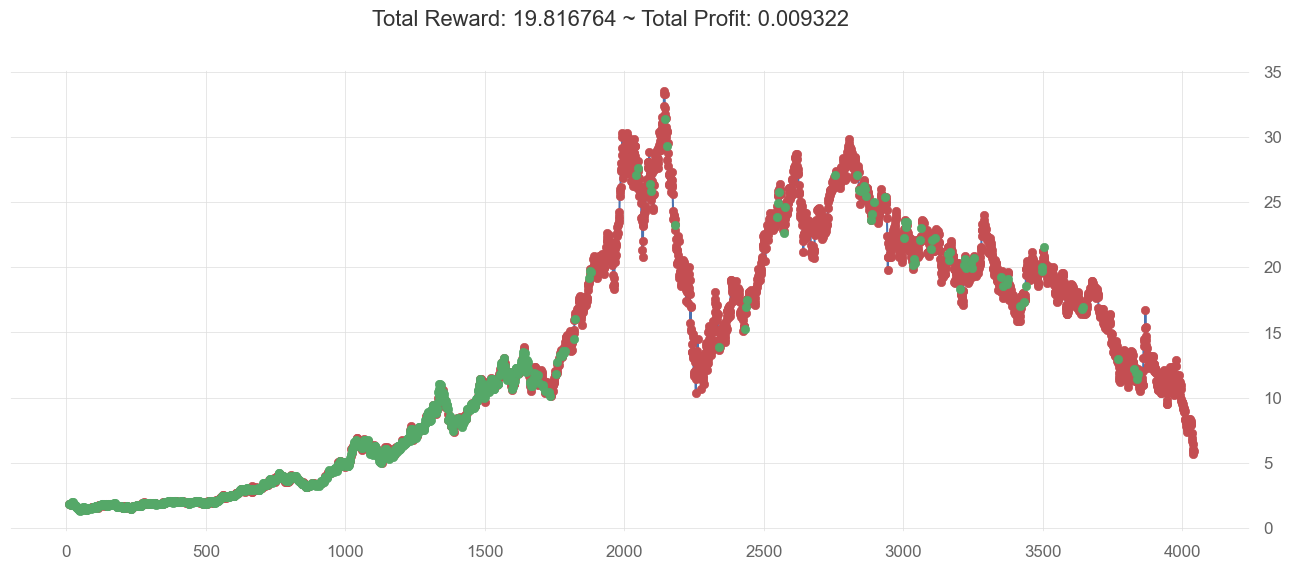

In [23]:
resultados_a2c_treino,env_treino= avaliando_algoritimo_trade(data,window_size=window_size,start=start_treino,final=end_treino,model=actor_critic,nome_coluna='A2C_treino',seed_random=semente)

<h3>Avaliando dados teste</h3>

action_stats: {<Actions.Sell: 0>: 1418, <Actions.Buy: 1>: 313}
info: {'total_reward': 5.032090187072754, 'total_profit': 0.2222783298413362, 'position': <Positions.Short: 0>}


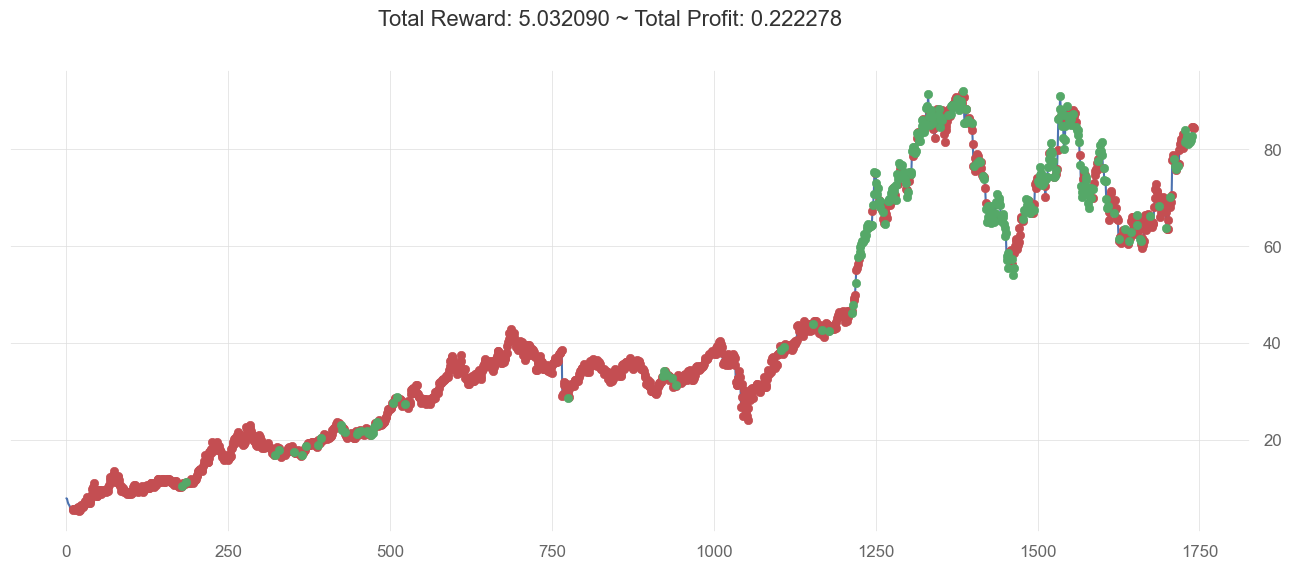

In [24]:
resultados_a2c_teste,env_teste = avaliando_algoritimo_trade(data,window_size=window_size,start=start_teste,final=end_teste,model=actor_critic,nome_coluna='a2c_teste',seed_random=semente)

                           Strategy
-------------------------  ----------
Start Period               2016-01-20
End Period                 2022-12-29
Risk-Free Rate             0.0%
Time in Market             7.0%

Cumulative Return          -77.77%
CAGR﹪                     -13.89%

Sharpe                     -1.37
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -1.36
Sortino                    -1.53
Smart Sortino              -1.52
Sortino/√2                 -1.08
Smart Sortino/√2           -1.07
Omega                      0.38

Max Drawdown               -79.52%
Longest DD Days            1976
Volatility (ann.)          15.13%
Calmar                     -0.17
Skew                       -6.51
Kurtosis                   108.82

Expected Daily %           -0.09%
Expected Monthly %         -1.77%
Expected Yearly %          -19.33%
Kelly Criterion            -47.52%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.65%
Expected Shortfall (cVaR)  -1.65%

Max Consecu

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2017-08-02  2022-12-27  2022-12-29  1976    -79.523915        -79.178309
2  2016-09-29  2016-09-29  2017-04-19   203     -2.578058               NaN
3  2017-06-29  2017-06-29  2017-07-24    26     -1.118642               NaN
4  2017-06-02  2017-06-02  2017-06-20    19     -1.088737               NaN

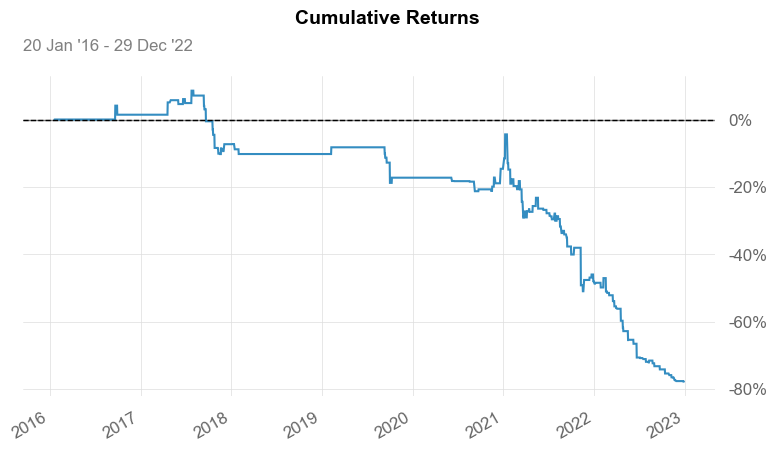

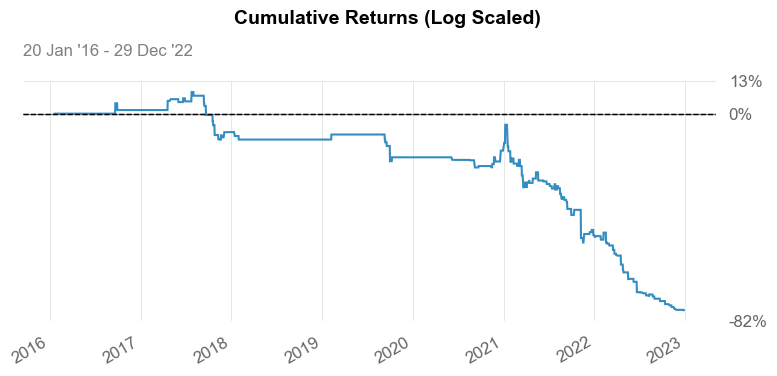

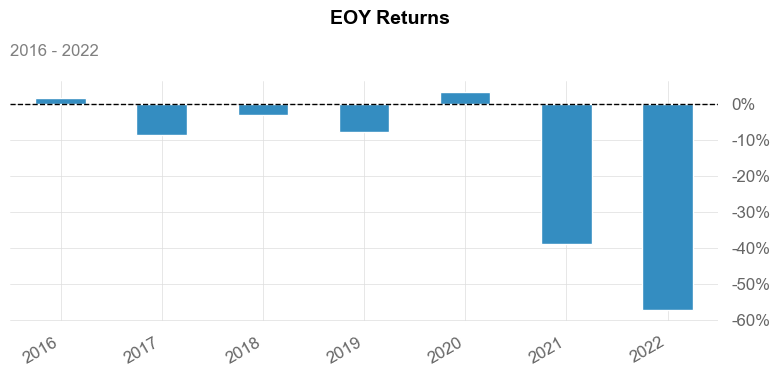

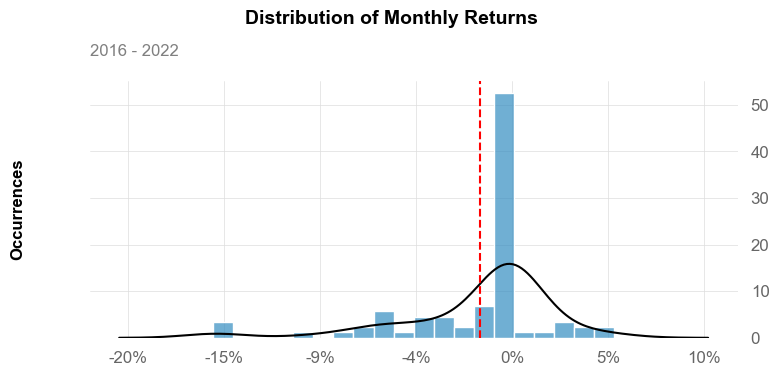

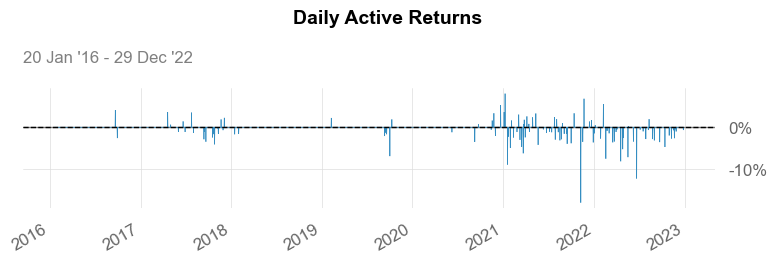

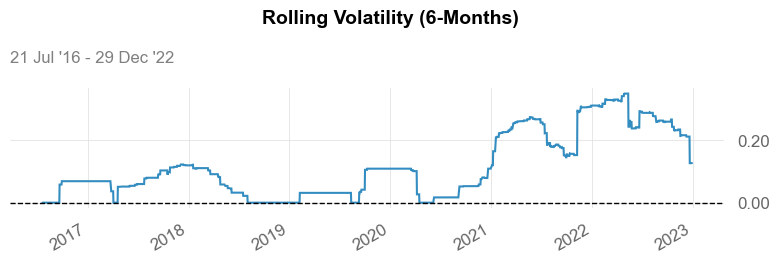

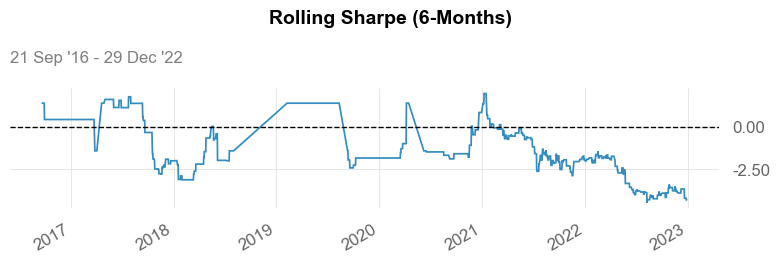

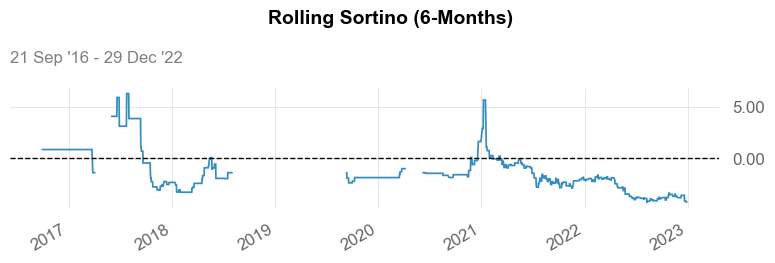

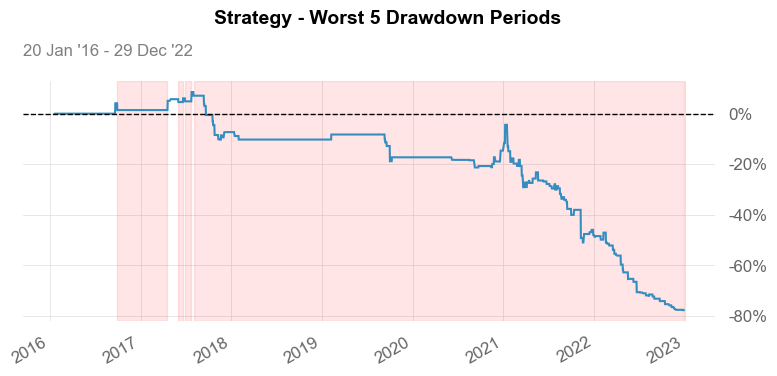

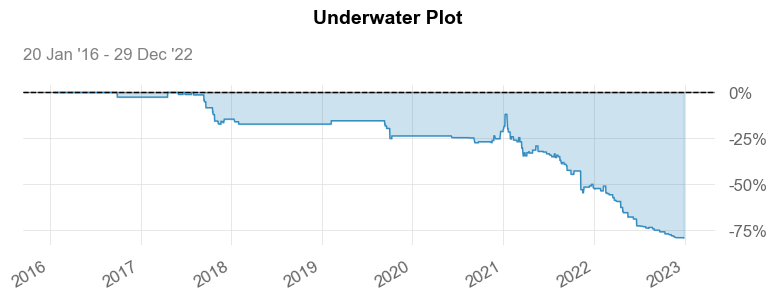

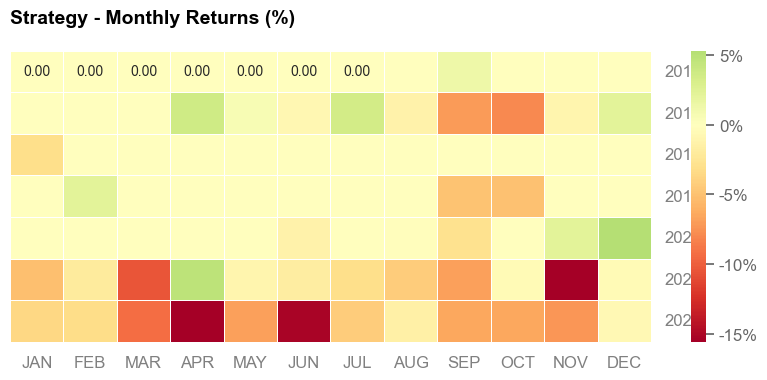

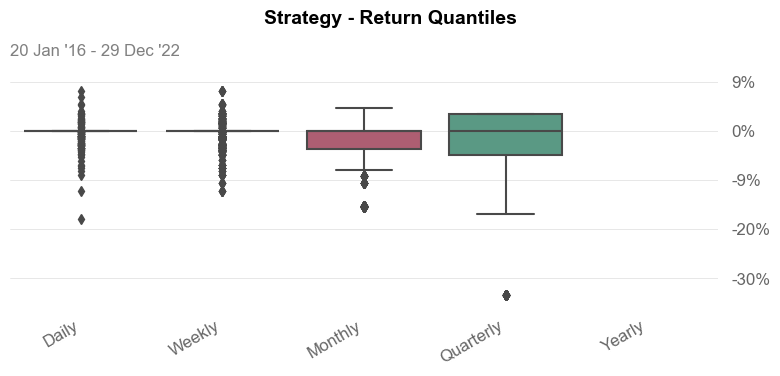

In [25]:
qs.extend_pandas()

net_worth = pd.Series(env_teste.history['total_profit'], index=data.index[start_teste+1:])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

<h2>Treinando o PPO</h1>

In [26]:
PPO = PPO('MlpPolicy', env, verbose=1)
PPO.learn(total_timesteps=iteracao, callback=eval_callback)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1855 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1220        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012525864 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | -0.36       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.228       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00626    |
|    value_loss           | 0.32        |
-----------------------------------------
-----------------

<h3>Avaliando dados de treino</h3>

action_stats: {<Actions.Sell: 0>: 2634, <Actions.Buy: 1>: 1396}
info: {'total_reward': 39.22496831417084, 'total_profit': 0.14504016446997492, 'position': <Positions.Short: 0>}


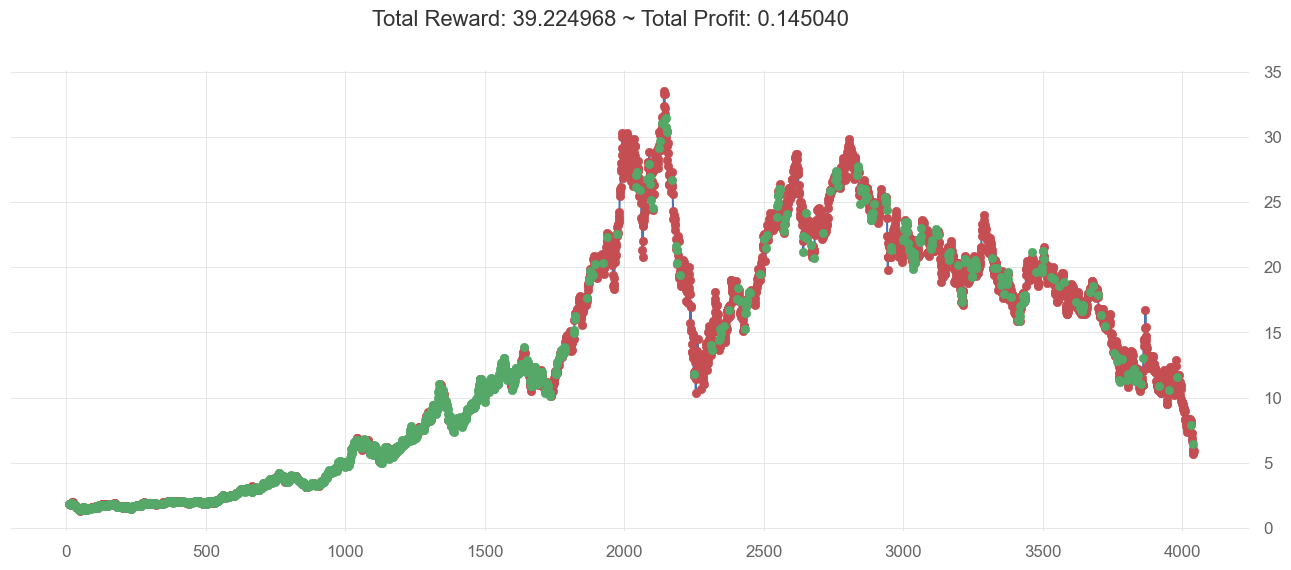

In [27]:
resultados_ppo_treino,env_treino= avaliando_algoritimo_trade(data,window_size=window_size,start=start_treino,final=end_treino,model=PPO,nome_coluna='ppo_treino',seed_random=semente)

<h3>Avaliando dados teste</h3>

action_stats: {<Actions.Sell: 0>: 1214, <Actions.Buy: 1>: 517}
info: {'total_reward': 9.780484676361084, 'total_profit': 0.023374215538571025, 'position': <Positions.Short: 0>}


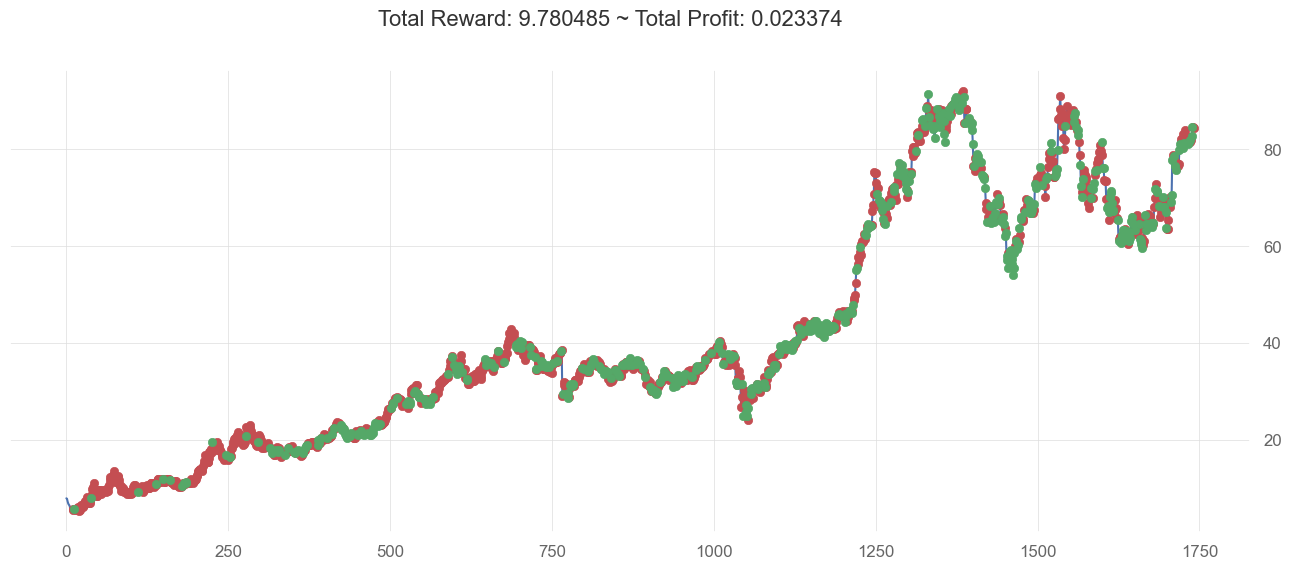

In [28]:
resultados_ppo_teste,env_teste = avaliando_algoritimo_trade(data,window_size=window_size,start=start_teste,final=end_teste,model=PPO,nome_coluna='ppo_teste',seed_random=semente)

                           Strategy
-------------------------  ----------
Start Period               2016-01-20
End Period                 2022-12-29
Risk-Free Rate             0.0%
Time in Market             17.0%

Cumulative Return          -97.66%
CAGR﹪                     -31.16%

Sharpe                     -2.16
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -2.12
Sortino                    -2.7
Smart Sortino              -2.65
Sortino/√2                 -1.91
Smart Sortino/√2           -1.87
Omega                      0.38

Max Drawdown               -98.1%
Longest DD Days            2334
Volatility (ann.)          23.95%
Calmar                     -0.32
Skew                       0.63
Kurtosis                   37.39

Expected Daily %           -0.22%
Expected Monthly %         -4.37%
Expected Yearly %          -41.53%
Kelly Criterion            -46.68%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.69%
Expected Shortfall (cVaR)  -2.69%

Max Consecutiv

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2016-08-09  2022-10-31  2022-12-29  2334    -98.102015        -97.976256
2  2016-01-21  2016-01-21  2016-03-01    41     -2.243685               NaN

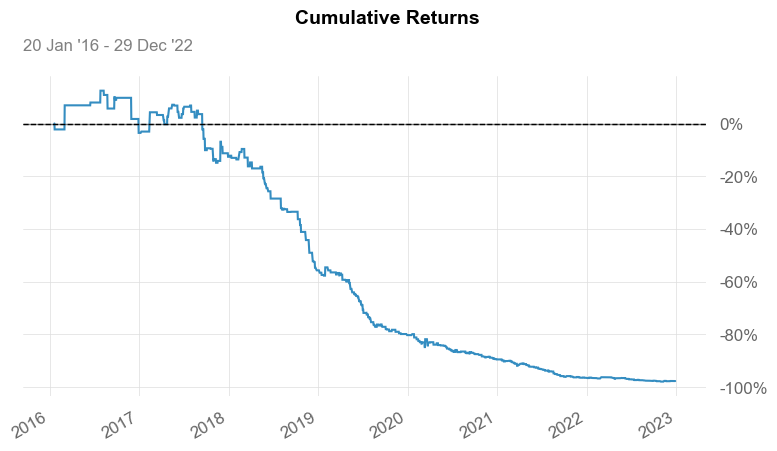

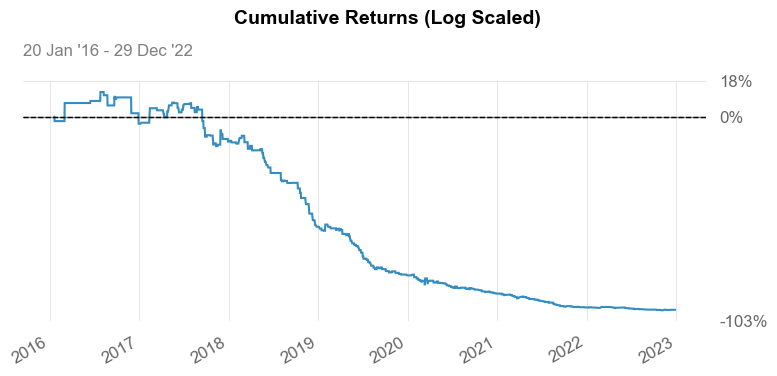

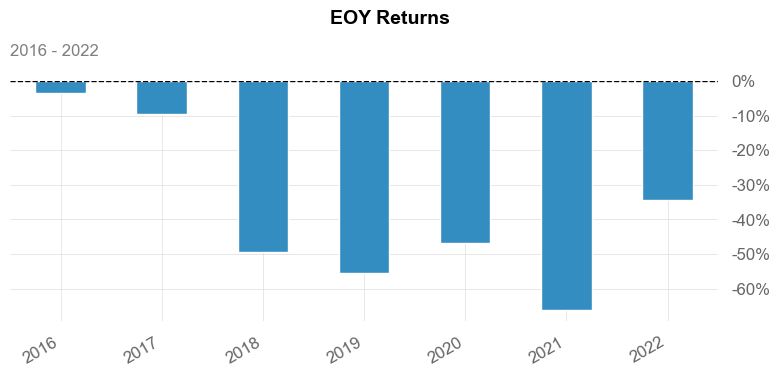

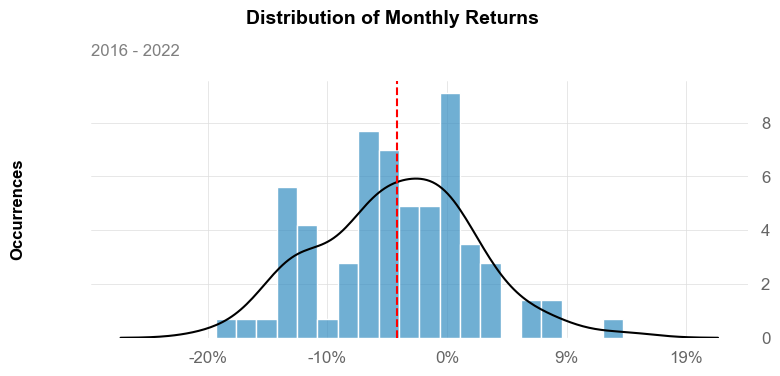

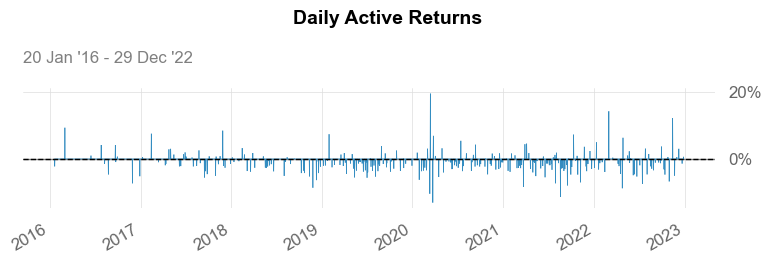

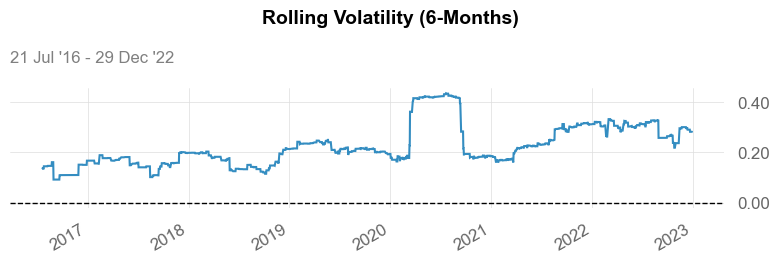

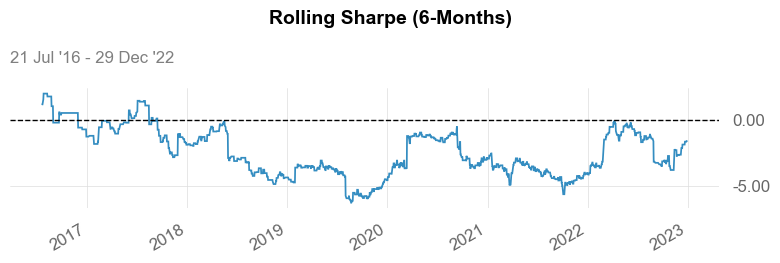

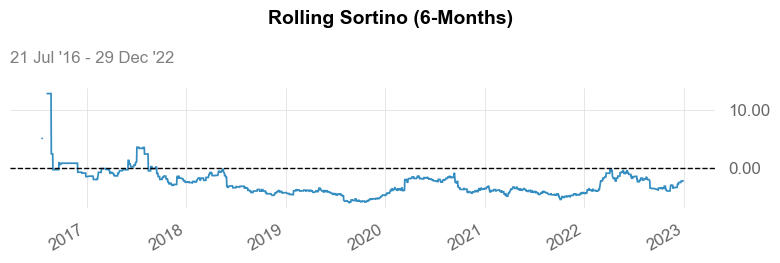

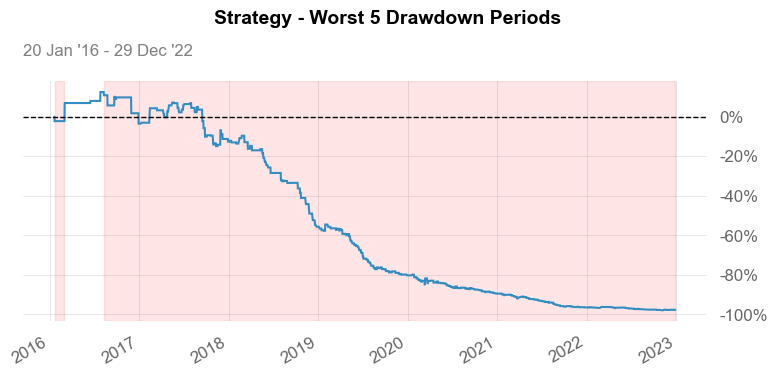

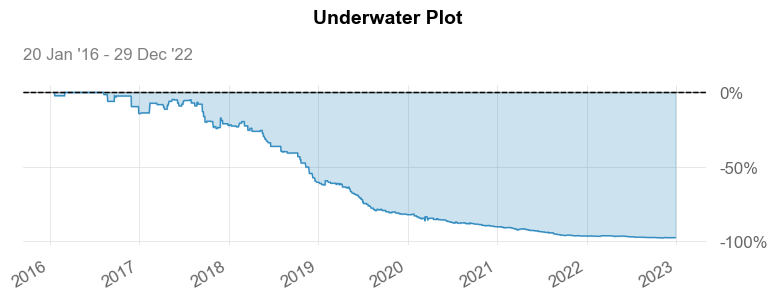

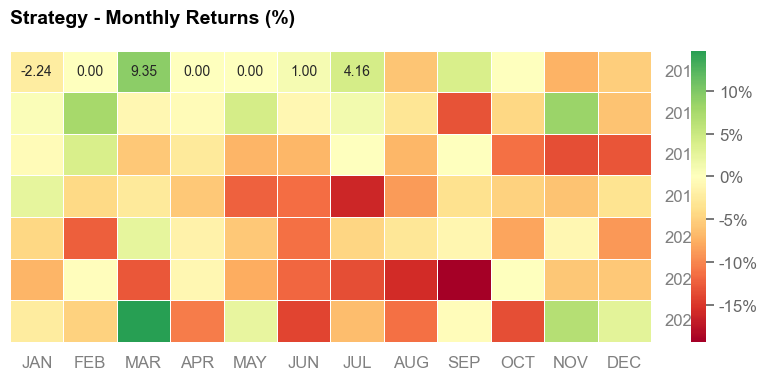

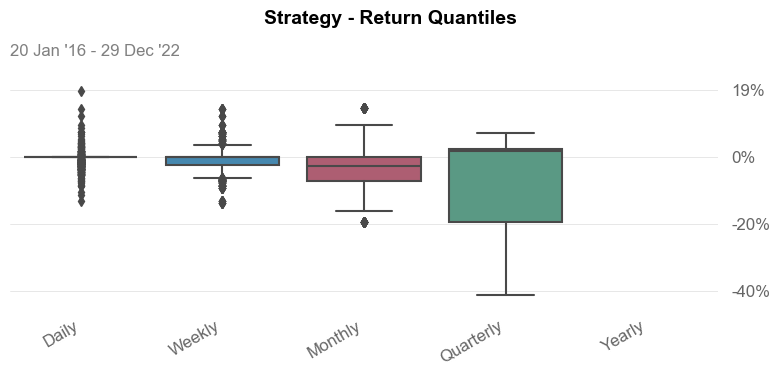

In [29]:
qs.extend_pandas()

net_worth = pd.Series(env_teste.history['total_profit'], index=data.index[start_teste+1:])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

<h1>Treinando DQN</h1>

In [30]:
DQN = DQN('MlpPolicy', env, verbose=1)
DQN.learn(total_timesteps=iteracao, callback=eval_callback)

Using cpu device
Eval num_timesteps=9104, episode_reward=15.76 +/- 0.00
Episode length: 4030.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.03e+03 |
|    mean_reward      | 15.8     |
| rollout/            |          |
|    exploration_rate | 0.957    |
| time/               |          |
|    total_timesteps  | 9104     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2822     |
|    time_elapsed     | 6        |
|    total_timesteps  | 17164    |
----------------------------------
Eval num_timesteps=19104, episode_reward=15.76 +/- 0.00
Episode length: 4030.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.03e+03 |
|    mean_reward      | 15.8     |
| rollout/            |          |
|

<h3>Avaliando dados treino</h3>

action_stats: {<Actions.Sell: 0>: 3528, <Actions.Buy: 1>: 502}
info: {'total_reward': 0.9333227872848511, 'total_profit': 0.0036688297975582683, 'position': <Positions.Short: 0>}


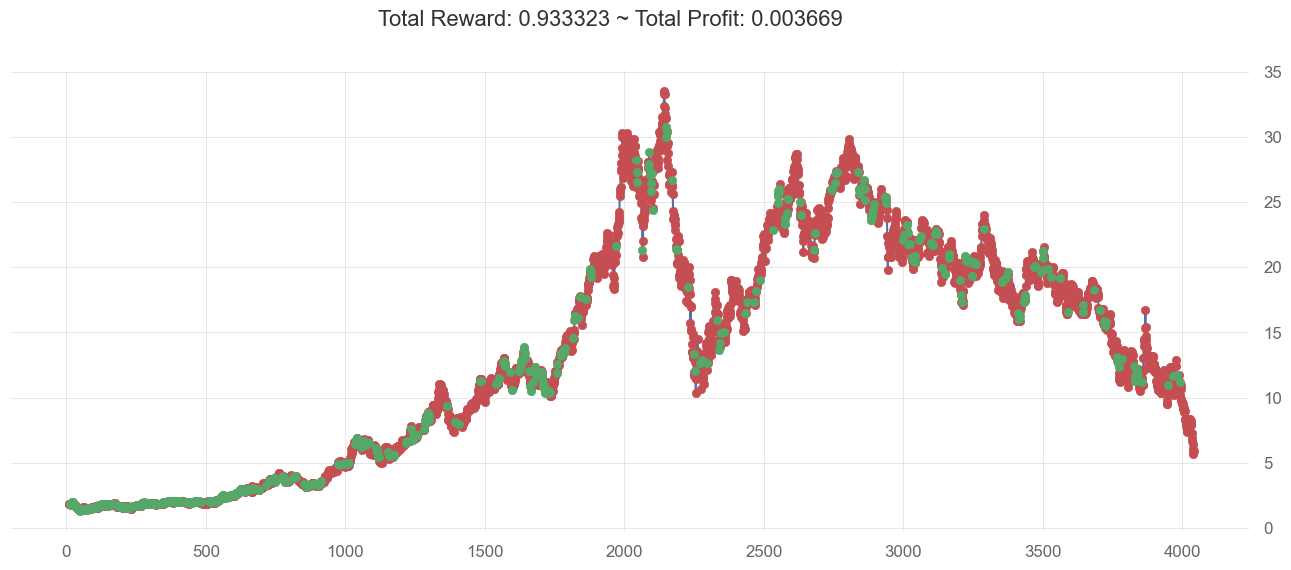

In [31]:
resultados_dqn_treino,env_treino= avaliando_algoritimo_trade(data,window_size=window_size,start=start_treino,final=end_treino,model=DQN,nome_coluna='dqn_treino',seed_random=semente)

<h3>Avaliando dados teste</h3>

action_stats: {<Actions.Sell: 0>: 1525, <Actions.Buy: 1>: 206}
info: {'total_reward': 0.26811695098876953, 'total_profit': 0.11058469702505275, 'position': <Positions.Short: 0>}


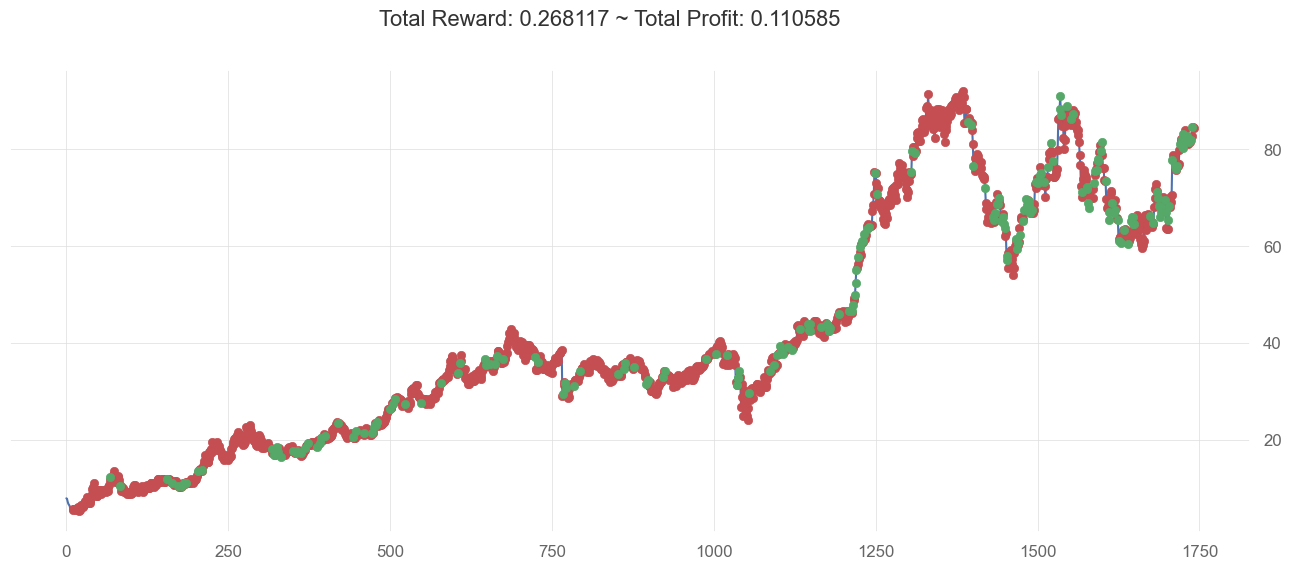

In [32]:
resultados_dqn_teste,env_teste = avaliando_algoritimo_trade(data,window_size=window_size,start=start_teste,final=end_teste,model=DQN,nome_coluna='dqn_teste',seed_random=semente)

                           Strategy
-------------------------  ----------
Start Period               2016-01-20
End Period                 2022-12-29
Risk-Free Rate             0.0%
Time in Market             10.0%

Cumulative Return          -88.94%
CAGR﹪                     -19.66%

Sharpe                     -2.14
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -2.1
Sortino                    -2.39
Smart Sortino              -2.35
Sortino/√2                 -1.69
Smart Sortino/√2           -1.66
Omega                      0.27

Max Drawdown               -88.94%
Longest DD Days            2451
Volatility (ann.)          14.49%
Calmar                     -0.22
Skew                       -2.78
Kurtosis                   40.75

Expected Daily %           -0.13%
Expected Monthly %         -2.59%
Expected Yearly %          -26.99%
Kelly Criterion            -71.65%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.62%
Expected Shortfall (cVaR)  -1.62%

Max Consecut

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2016-04-14  2022-12-28  2022-12-29  2451     -88.94153        -88.121245

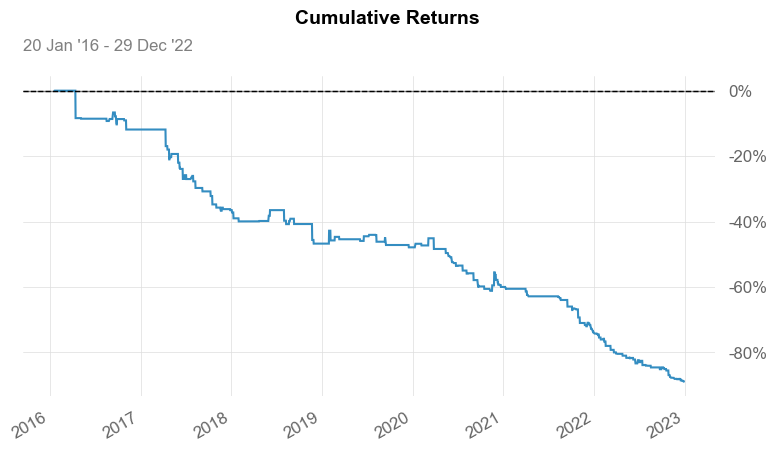

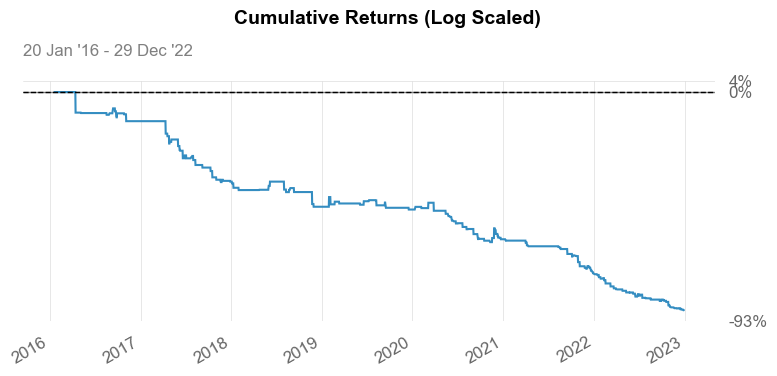

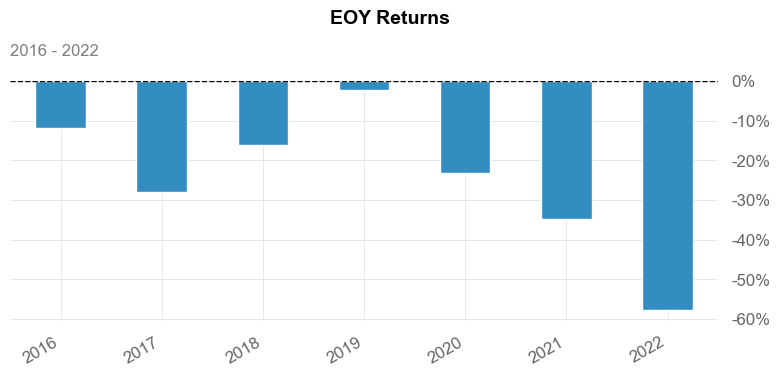

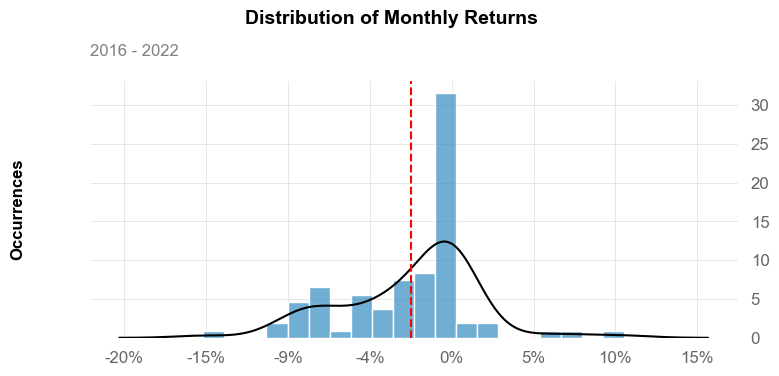

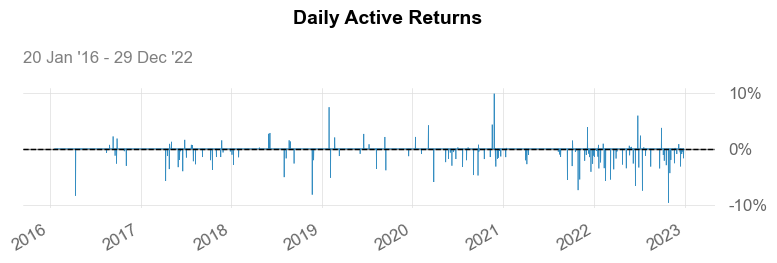

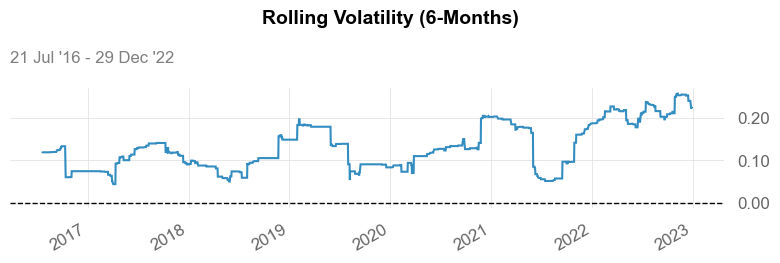

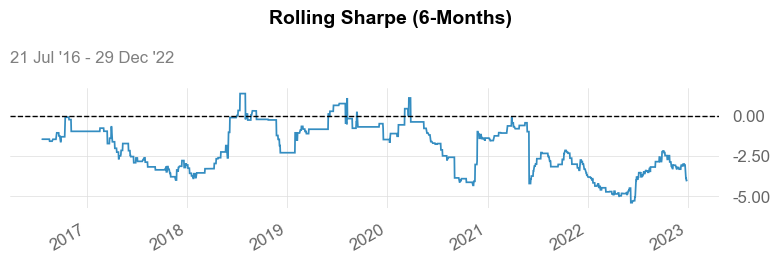

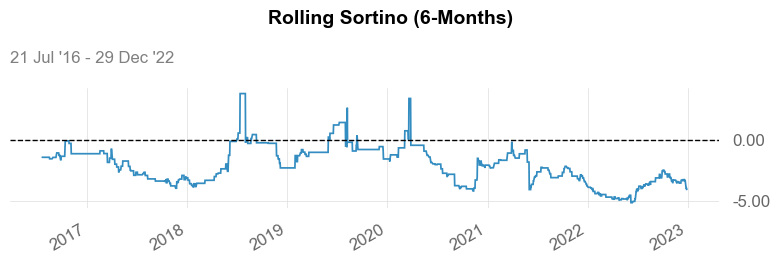

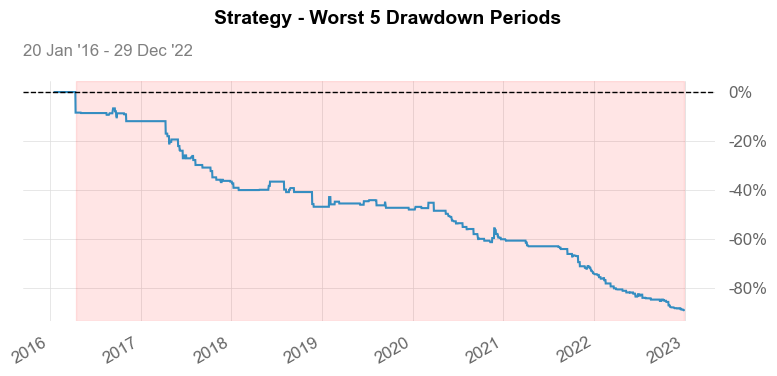

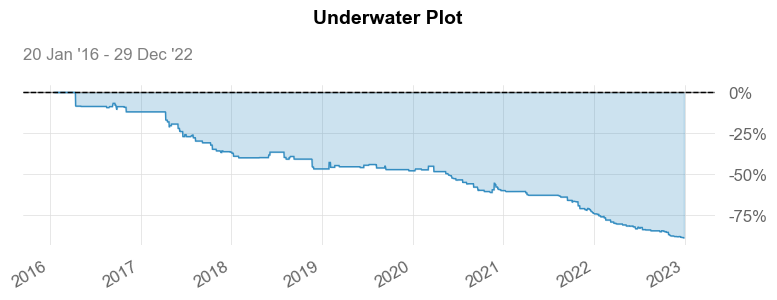

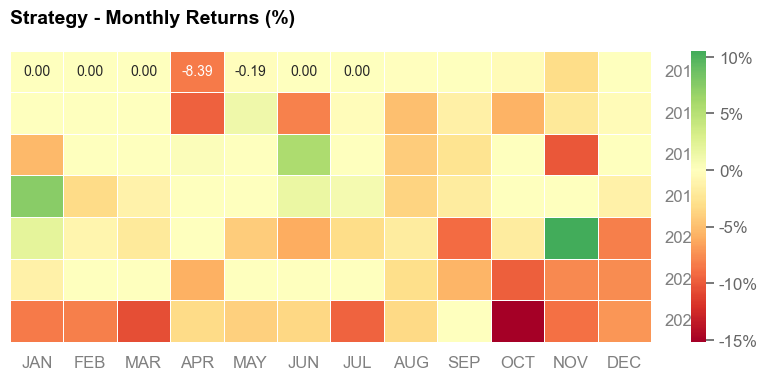

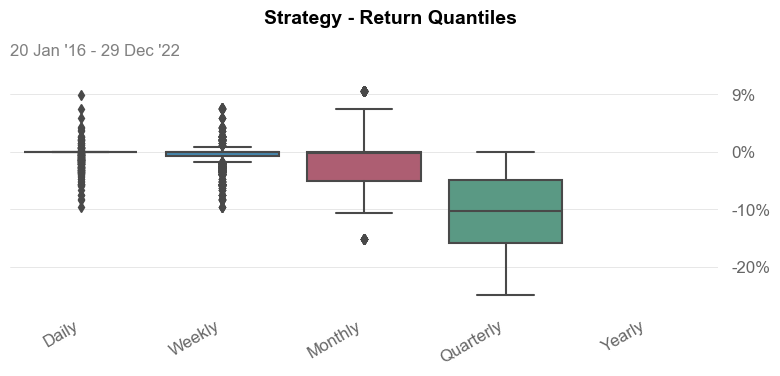

In [33]:
qs.extend_pandas()

net_worth = pd.Series(env_teste.history['total_profit'], index=data.index[start_teste+1:])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

<h1>Avaliando os algoritimos juntos</h1>

In [34]:
pd.concat([resultados_a2c_treino,resultados_a2c_teste,resultados_ppo_treino,resultados_ppo_teste,resultados_dqn_treino,resultados_dqn_teste])

Recompensa  Resultado da Carteira  Posições_Longas  \
A2C_treino       19.82                   0.01             1013   
a2c_teste         5.03                   0.22              313   
ppo_treino       39.22                   0.15             1396   
ppo_teste         9.78                   0.02              517   
dqn_treino        0.93                   0.00              502   
dqn_teste         0.27                   0.11              206   

            Posições_Curtas  
A2C_treino             3017  
a2c_teste              1418  
ppo_treino             2634  
ppo_teste              1214  
dqn_treino             3528  
dqn_teste              1525